# Model A

Model A is trained using random time points for each patient. We first train this model, then evaluate it on a separate dataset with data extracted at fixed lead times from mortality for the patients who died in-hospital.

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties # for unicode fonts
import psycopg2
import sys
import datetime as dt
import mp_utils as mp

from collections import OrderedDict

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

from sklearn.pipeline import Pipeline

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

# below config used on pc70
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [3]:
# exclusion criteria:
#   - less than 16 years old
#   - stayed in the ICU less than 4 hours
#   - never have any chartevents data (i.e. likely administrative error)
query = query_schema + \
"""
select 
    subject_id, hadm_id, icustay_id
from mp_cohort
where excluded = 0
"""
co = pd.read_sql_query(query,con)

# extract static vars into a separate dataframe
df_static = pd.read_sql_query(query_schema + 'select * from mp_static_data', con)

In [4]:
# get ~5 million rows containing data from errbody
# this takes a little bit of time to load into memory (~2 minutes)

# %%time results
# CPU times: user 42.8 s, sys: 1min 3s, total: 1min 46s
# Wall time: 2min 7s

df = pd.read_sql_query(query_schema + 'select * from mp_data', con)
df.drop('subject_id',axis=1,inplace=True)
df.drop('hadm_id',axis=1,inplace=True)
df.sort_values(['icustay_id','hr'],axis=0,ascending=True,inplace=True)
print(df.shape)

(6397941, 54)


In [5]:
# get death information
df_death = pd.read_sql_query(query_schema + """
select 
co.subject_id, co.hadm_id, co.icustay_id
, ceil(extract(epoch from (co.outtime - co.intime))/60.0/60.0) as dischtime_hours
, ceil(extract(epoch from (adm.deathtime - co.intime))/60.0/60.0) as deathtime_hours
, case when adm.deathtime is null then 0 else 1 end as death
from mp_cohort co
inner join admissions adm
on co.hadm_id = adm.hadm_id
where co.excluded = 0
""", con)

In [6]:
# get censoring information
df_censor = pd.read_sql_query(query_schema + """
select co.icustay_id, min(cs.charttime) as censortime
, ceil(extract(epoch from min(cs.charttime-co.intime) )/60.0/60.0) as censortime_hours
from mp_cohort co 
inner join mp_code_status cs
on co.icustay_id = cs.icustay_id
where cmo+dnr+dni+dncpr+cmo_notes>0
and co.excluded = 0
group by co.icustay_id
""", con)

## Model 2: Ensure we do not pull data if patient is DNR

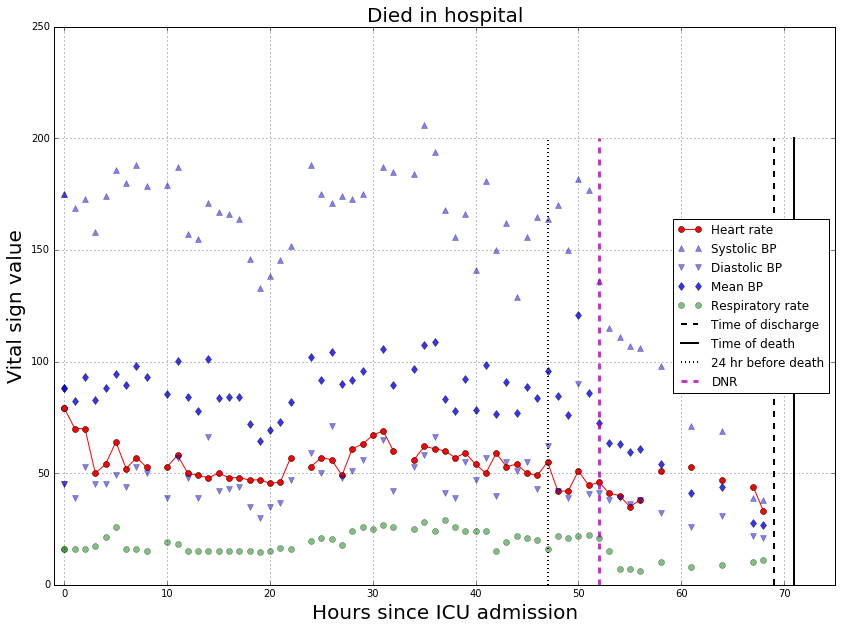

In [7]:
# example of why this may be necessary
mp.plot_vitals(df, iid=200019, df_death=df_death, df_censor=df_censor)

In [9]:
K = 5 # number of folds
var_min, var_max, var_first, var_last, var_sum, var_first_early, var_last_early, var_static = vars_of_interest()

df_tmp=df_death.copy().merge(df_censor, how='left', left_on='icustay_id', right_on='icustay_id')
time_dict = mp.generate_times(df_tmp, T=2, seed=111, censor=True)
df_data = mp.get_design_matrix(df, time_dict, W=4, W_extra=24)

# remove icustay_ids if they were censored (made DNR) before icu admission, or close enough to that
idx = df_censor.loc[df_censor['censortime_hours']<=0, 'icustay_id']
print('Removed {} icustay_id as they were censored on/before ICU admission.'.format((idx.shape[0])))
df_data.drop(idx, axis=0, inplace=True)

# get unique subject_id
sid = np.sort(np.unique(df_death['subject_id'].values))

# assign k-fold
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, df_death['subject_id'].values)

# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]

# first, the data from static vars from df_static
X = df_data.merge(df_static.set_index('icustay_id')[vars_static], how='left', left_index=True, right_index=True)
# next, add in the outcome: death in hospital
X = X.merge(df_death.set_index('icustay_id')[['death']], left_index=True, right_index=True)

# generate K-fold indices
X = X.merge(df_death.set_index('icustay_id')[['subject_id']], left_index=True, right_index=True)

# get unique subject_id
sid = np.sort(np.unique(X['subject_id'].values))

# assign k-fold
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, X['subject_id'].values)

# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]

# drop the subject_id column
X.drop('subject_id',axis=1,inplace=True)

# convert to numpy data (assumes target, death, is the last column)
X = X.values
y = X[:,-1]
X = X[:,0:-1]
X_header = vars_static + [x for x in df_data.columns.values]

Removed 1122 icustay_id as they were censored on/before ICU admission.


In [43]:
# Rough timing info:
#     rf - 3 seconds per fold
#    xgb - 30 seconds per fold
# logreg - 4 seconds per fold
#  lasso - 8 seconds per fold
models = {'xgb': xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05),
          'lasso': LassoCV(cv=5,fit_intercept=True,normalize=True,max_iter=10000),
          'logreg': LogisticRegression(fit_intercept=True),
          'rf': RandomForestClassifier()
         }


# create k-fold indices
K = 5 # number of folds
idxK = np.random.permutation(X.shape[0])
idxK = np.mod(idxK,K)

mdl_val = dict()
results_val = dict()

for mdl in models:
    print('=============== {} ==============='.format(mdl))
    mdl_val[mdl] = list()
    results_val[mdl] = list() # initialize list for scores

    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])]) 

    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = sklearn.base.clone(estimator).fit(X[idxK != k, :], y[idxK != k])

        # get prediction on this dataset
        if mdl == 'lasso':
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]

        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        results_val[mdl].append(curr_score)

        # save the current model
        mdl_val[mdl].append(curr_mdl)
        
        print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))

=============== rf ===============
2017-02-27 18:59:22.055817 - Finished fold 1 of 5. AUROC 0.840.
2017-02-27 18:59:24.025206 - Finished fold 2 of 5. AUROC 0.843.
2017-02-27 18:59:25.943649 - Finished fold 3 of 5. AUROC 0.841.
2017-02-27 18:59:28.297218 - Finished fold 4 of 5. AUROC 0.845.
2017-02-27 18:59:30.718156 - Finished fold 5 of 5. AUROC 0.830.
=============== xgb ===============
2017-02-27 18:59:43.624927 - Finished fold 1 of 5. AUROC 0.908.
2017-02-27 18:59:56.444176 - Finished fold 2 of 5. AUROC 0.908.
2017-02-27 19:00:08.259355 - Finished fold 3 of 5. AUROC 0.903.
2017-02-27 19:00:21.414168 - Finished fold 4 of 5. AUROC 0.909.
2017-02-27 19:00:32.985560 - Finished fold 5 of 5. AUROC 0.905.
=============== logreg ===============
2017-02-27 19:00:37.473082 - Finished fold 1 of 5. AUROC 0.880.
2017-02-27 19:00:41.936453 - Finished fold 2 of 5. AUROC 0.878.
2017-02-27 19:00:45.868823 - Finished fold 3 of 5. AUROC 0.880.
2017-02-27 19:00:50.329669 - Finished fold 4 of 5. AUROC 0

In [67]:
# average AUROC + min/max
for mdl in models:
    curr_score = np.asarray(results_val[mdl],dtype=float)
    print('{}\t{:0.3f} [{:0.3f}, {:0.3f}]'.format(mdl, np.mean(curr_score), np.min(curr_score), np.max(curr_score)))

rf	0.840 [0.830, 0.845]
xgb	0.907 [0.903, 0.909]
logreg	0.879 [0.875, 0.883]
lasso	0.874 [0.868, 0.876]


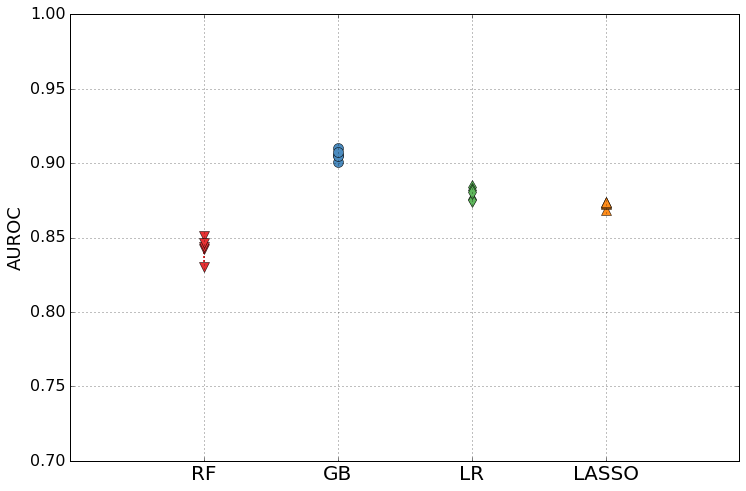

In [30]:
mp.plot_model_results(results_val)

# Plot a single patient's trend

In [ ]:
iid = 200019
mdl='xgb'

pred_all = None
for k in range(K):
    # get patient time/predictions
    curr_mdl = mdl_val[mdl][k]
    t, pred = mp.get_predictions(df, df_static, curr_mdl, iid)
    
    if pred_all is None:
        pred_all = pred
    else:
        pred_all = np.column_stack([pred_all, pred])
        
    #plt.plot(t, pred, color=col[k],
    #        markersize=10, linewidth=2, linestyle='-',
    #        label=mdl + '{}'.format(k))
    
pred_top = np.max(pred_all,axis=1)
pred_bot = np.min(pred_all,axis=1)
pred_mean = np.mean(pred_all,axis=1)

fig, ax = plt.subplots(1,1,figsize=[12,8])
ax.plot(t, pred_mean, color=col[0],
        markersize=10, linewidth=2, linestyle='-',
        label='Average prediction')
ax.fill_between(t, pred_bot, pred_top, facecolor=col[0],
                alpha=0.5, linewidth=0, interpolate=True)
plt.show()

# Evaluate model before death

In [ ]:
# creates datasets in X_all for evaluation

# experiment elements contain a list: [seed, W (window size), T_to_death]
experiments = OrderedDict([['base', [473010,8,None]],
               ['24hr', [585794,24,None]],
               ['Td=00', [724311,8,0]],
               ['Td=04', [952227,8,4]],
               ['Td=08', [721297,8,8]],
               ['Td=16', [968879,8,16]],
               ['Td=24', [608972,8,24]],
               ['24hr Td=00', [34741,24,0]],
               ['24hr Td=04', [34319,24,4]],
               ['24hr Td=08', [95467,24,8]],
               ['24hr Td=16', [85349,24,16]],
               ['24hr Td=24', [89642,24,24]]
                          ])

# fuzzyness to allow deathtime to be a little bit after discharge time
death_epsilon=2
X_all = dict()
y_all = dict()
iid_all = dict()
pred_all = dict()
time_all = dict()
X_header_all = dict()

for e in experiments:
    params = experiments[e]
    time_all[e] = mp.generate_times_before_death(df_death, seed=params[0], T=None, T_to_death=params[2])
    df_data = mp.get_design_matrix(df, time_all[e], W=params[1], W_extra=24)
    
    # load the data into a numpy array
        
    # Add in static vars from df_static
    X = df_data.merge(df_static.set_index('icustay_id')[vars_static],
                      how='left', left_index=True, right_index=True)
    
    
    if params[2] is not None:
        df_tmp = df_death[['icustay_id','death','dischtime_hours', 'deathtime_hours']].copy()
        df_tmp['death_in_icu'] = (df_tmp['deathtime_hours']<=(df_tmp['dischtime_hours']+params[2]+death_epsilon)).astype(float)
        X = X.merge(df_tmp[['icustay_id','death_in_icu']].set_index('icustay_id'),
                          left_index=True, right_index=True)
    else:
        X = X.merge(df_death[['icustay_id','death']].set_index('icustay_id'),
                          left_index=True, right_index=True)

    iid_all[e] = X.index.values
    X = X.values
    y_all[e] = X[:,-1]
    X_all[e] = X[:,0:-1]
    
    X_header_all[e] = df_data.columns

In [40]:
# evaluate the models on various datasets
K = 5 # number of folds
results_all = dict()
mdl_base = dict()
base_exp = 'base'

# train the base model
e = base_exp

# get unique subject_id
sid = np.sort(np.unique(df_death['subject_id'].values))

# assign k-fold
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, df_death['subject_id'].values)

# use these indices to map the k-fold integers
idxK_all = idxK_sid[idxMap]

# get the data for the dataset which the model is developed on
X = X_all[e]
y = y_all[e]
iid_curr = iid_all[e]

# map the k-fold indices from all IID to the subset included in this data
iid = df_death['icustay_id'].values
idxMap = np.nonzero(np.in1d(iid,iid_curr))[0]
idxK = idxK_all[idxMap]

results_all[e] = dict()


idxMap = np.nonzero(np.in1d(iid,iid_curr))[0]

for mdl in models:
    # train the model for the fixed dataset
    print('=============== {} ==============='.format(mdl))
    
    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])])
    print('Training 5-fold model for application to various datasets...'.format(K))
    
    results_all[e][mdl] = list()
    mdl_base[mdl] = list()
    
    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = sklearn.base.clone(estimator).fit(X[idxK != k, :], y[idxK != k])

        # get prediction on this dataset
        if mdl == 'lasso':
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]

        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        results_all[e][mdl].append(curr_score)

        # save the current model
        mdl_base[mdl].append(curr_mdl)

        print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))

    # apply the trained model to each dataset in experiments
    for e in experiments:
        if e == base_exp:
            continue
            
        if e not in results_all:
            results_all[e] = dict()
        results_all[e][mdl] = list()

        X = X_all[e]
        y = y_all[e]
        iid_curr = iid_all[e]
        
        # map the k-fold indices from all IID to the subset included in this data
        idxMap = np.nonzero(np.in1d(iid,iid_curr))[0]
        idxK = idxK_all[idxMap]
        
        
        if mdl == 'xgb':
            # no pre-processing of data necessary for xgb
            estimator = Pipeline([(mdl, models[mdl])])

        else:
            estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                              strategy="mean",
                                              axis=0)),
                          ("scaler", StandardScaler()),
                          (mdl, models[mdl])]) 

        for k in range(K):
            # train the model using all but the kth fold
            curr_mdl = mdl_base[mdl][k]

            # get prediction on this dataset
            if mdl == 'lasso':
                curr_prob = curr_mdl.predict(X[idxK == k, :])
            else:
                curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
                curr_prob = curr_prob[:,1]

            # calculate score (AUROC)
            curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

            # add score to list of scores
            results_all[e][mdl].append(curr_score)

        print('{} - {:10s} - AUROC {:0.3f} [{:0.3f}, {:0.3f}]'.format(dt.datetime.now(), e,
                                                                    np.mean(results_all[e][mdl]),
                                                                    np.min(results_all[e][mdl]),
                                                                    np.max(results_all[e][mdl])))

NameError: name 'X_all' is not defined

In [ ]:
# plot a figure of the results
marker = ['o','s','x','d']
xi_str = ['Td=00','Td=04','Td=08','Td=16','Td=24']
xi = [int(x[-2:]) for x in xi_str]

plt.figure(figsize=[14,10])
for m, mdl in enumerate(models):
    all_score = list()
    for i, x in enumerate(xi_str):
        curr_score = results_all[x][mdl]

        plt.plot(xi[i] * np.ones(len(curr_score)), curr_score,
                marker=marker[m], color=col[m],
                markersize=10, linewidth=2, linestyle=':')

        all_score.append(np.median(curr_score))
        
    # plot a line through the mean across all evaluations

    plt.plot(xi, all_score,
            marker=marker[m], color=col[m],
            markersize=10, linewidth=2, linestyle='-',
            label=mdl)

plt.gca().set_xticks(np.linspace(0,24,7))
plt.gca().set_xlim([-1,25])
plt.gca().invert_xaxis()
plt.legend(loc='lower center',fontsize=16)
plt.xlabel('Lead time (hours)',fontsize=18)
plt.ylabel('AUROC',fontsize=18)

ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

plt.grid()
#plt.savefig('auroc_over_time_dw24.pdf')
plt.show()

# Add treatment

In [ ]:
K = 5 # number of folds
var_min, var_max, var_first, var_last, var_sum, var_first_early, var_last_early, var_static = vars_of_interest()

df_tmp=df_death.copy().merge(df_censor, how='left', left_on='icustay_id', right_on='icustay_id')
time_dict = mp.generate_times(df_tmp, T=2, seed=111, censor=True)
df_data = mp.get_design_matrix(df, time_dict, W=4, W_extra=24)

# remove icustay_ids if they were censored (made DNR) before icu admission, or close enough to that
idx = df_censor.loc[df_censor['censortime_hours']<=0, 'icustay_id']
print('Removed {} icustay_id as they were censored on/before ICU admission.'.format((idx.shape[0])))
df_data.drop(idx, axis=0, inplace=True)

# get unique subject_id
sid = np.sort(np.unique(df_death['subject_id'].values))

# assign k-fold
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, df_death['subject_id'].values)

# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]

# first, the data from static vars from df_static
X = df_data.merge(df_static.set_index('icustay_id')[vars_static], how='left', left_index=True, right_index=True)
# next, add in the outcome: death in hospital
X = X.merge(df_death.set_index('icustay_id')[['death']], left_index=True, right_index=True)

# generate K-fold indices
X = X.merge(df_death.set_index('icustay_id')[['subject_id']], left_index=True, right_index=True)

# get unique subject_id
sid = np.sort(np.unique(X['subject_id'].values))

# assign k-fold
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, X['subject_id'].values)

# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]

# drop the subject_id column
X.drop('subject_id',axis=1,inplace=True)

# convert to numpy data (assumes target, death, is the last column)
X = X.values
y = X[:,-1]
X = X[:,0:-1]
X_header = vars_static + [x for x in df_data.columns.values]

In [ ]:
# plot a figure of the results
marker = ['o','s','x','d']

for m, mdl in enumerate(models):
    all_score = list()
    for i, x in enumerate(xi_str):
        curr_score = results_all[x][mdl]

        plt.plot(xi[i] * np.ones(len(curr_score)), curr_score,
                marker=marker[m], color=col[m],
                markersize=10, linewidth=2, linestyle=':')

        all_score.append(np.median(curr_score))
        
    # plot a line through the mean across all evaluations

    plt.plot(xi, all_score,
            marker=marker[m], color=col[m],
            markersize=10, linewidth=2, linestyle='-',
            label=mdl)

plt.gca().set_xticks(np.linspace(0,24,7))
plt.gca().set_xlim([-1,25])
plt.gca().invert_xaxis()
plt.legend(loc='lower center',fontsize=16)
plt.xlabel('Lead time (hours)',fontsize=18)
plt.ylabel('AUROC',fontsize=18)

ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

plt.grid()
#plt.savefig('auroc_over_time_dw24.pdf')
plt.show()

# Relative feature importance at T=0 vs T=24

In [ ]:
B=100

mdl = 'xgb'

# apply the trained model to each dataset in experiments
e1 = 'Td=24'
e2 = 'Td=00'

X1 = X_all[e1]
y1 = y_all[e1]
iid_curr1 = iid_all[e1]
X2 = X_all[e2]
y2 = y_all[e2]
iid_curr2 = iid_all[e2]

# map the k-fold indices from all IID to the subset included in this data
idxMap = np.nonzero(np.in1d(iid,iid_curr1))[0]
idxK1 = idxK_all[idxMap]
idxMap = np.nonzero(np.in1d(iid,iid_curr2))[0]
idxK2 = idxK_all[idxMap]

imp1 = np.zeros([B,X1.shape[1]])
imp2 = np.zeros([B,X2.shape[1]])

for k in range(K):
    # get model
    curr_mdl = mdl_base[mdl][k]
    print('========= {} ========='.format(mdl))
    # get data
    
    # mess up one column at a time
    for d in range(X.shape[1]):
        for b in range(B):
            X1_mess = X1.copy()
            idxRand = np.random.randint(0, high=X1.shape[0], size=X1.shape[0])
            X1_mess[:,d] = X1_mess[idxRand,d]
            
            X2_mess = X2.copy()
            idxRand = np.random.randint(0, high=X2.shape[0], size=X2.shape[0])
            X2_mess[:,d] = X2_mess[idxRand,d]
            
            # make predictions
            if mdl == 'lasso':
                curr_prob1 = curr_mdl.predict(X1_mess[idxK1 == k, :])
                curr_prob2 = curr_mdl.predict(X2_mess[idxK2 == k, :])
            else:
                curr_prob1 = curr_mdl.predict_proba(X1_mess[idxK1 == k, :])
                curr_prob1 = curr_prob1[:,1]
                curr_prob2 = curr_mdl.predict_proba(X2_mess[idxK2 == k, :])
                curr_prob2 = curr_prob2[:,1]

            # average loss of prediction (dataset 1)
            imp1[b,d] = metrics.log_loss(y1[idxK1 == k], curr_prob1)
            # average loss of prediction (dataset 2)
            imp2[b,d] = metrics.log_loss(y2[idxK2 == k], curr_prob2)
            
        if np.mod(d,10)==0:
            print('{:3g} of {:3g}.'.format(d, X.shape[1]))


# calculate difference

In [ ]:
reload(mp)
mdl = 'xgb'

xgb_model = mdl_base[mdl][0].steps[0][1]
plt.figure(figsize=[14,20])
ax = plt.gca()
mp.plot_xgb_importance_fmap(xgb_model, X_header=X_header,
                            importance_type='gain', ax=ax)
plt.show()